# Order by Order analysis of RVs of GL667C created by Wobble
## June 2021


### Package Imports

In [1]:
from datetime import time
import numpy as np
from numpy.core.defchararray import upper
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
import arviz as az
import os
import wobble
import exoplanet as xo
from astropy.modeling import models, fitting
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/z5345592/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/z5345592/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/z5345592/anaconda3/envs/py37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qi

In [2]:
def load_results(results_txt, results_hdf5):
    results = results_txt
    results = pd.read_csv(results, skiprows=3, delim_whitespace=True)
    results_hdf5 = results_hdf5
    results_hdf5 = wobble.Results(filename = results_hdf5)

    return results, results_hdf5

In [3]:
results, results_hdf5 = load_results('/home/z5345592/projects/gl667c_wobble/results_rvs_lr20.txt', '/home/z5345592/projects/gl667c_wobble/results_no_bad_orders_lr20.hdf5')
# results, results_hdf5 = load_results('/home/z5345592/projects/gl667c_wobble/results_rvs_lr50.txt', '/home/z5345592/projects/gl667c_wobble/results_no_bad_orders_lr20.hdf5')
# results, results_hdf5 = load_results('/home/z5345592/projects/gl667c_wobble/results_rvs_lr100.txt', '/home/z5345592/projects/gl667c_wobble/results_no_bad_orders_lr20.hdf5')
# results, results_hdf5 = load_results('/home/z5345592/projects/gl667c_wobble/results_rvs_lr200.txt', '/home/z5345592/projects/gl667c_wobble/results_no_bad_orders_lr20.hdf5')
# results, results_hdf5 = load_results('/home/z5345592/projects/gl667c_wobble/results_rvs_lr1000.txt', '/home/z5345592/projects/gl667c_wobble/results_no_bad_orders_lr20.hdf5')


Results: reading from /home/z5345592/projects/gl667c_wobble/results_no_bad_orders_lr20.hdf5


### Some common things throughout the analysis

times are the same for everything, and we're only looking at GL667C

In [4]:
times = np.array(results['dates']) #reassigning dates to times so (I think) the PYMC3 code works better later
star_name = 'GL667c (via wobble)' #to differentiate from the pipelines generated by the HARPS pipeline.

In [5]:
# rv_lr_list = [20,50,100,200,400,1000]
# for lr in rv_lr_list:
    
#     txt_results_filename = data_dir + 'results_rvs_lr{}.txt'.format(lr)
#     hdf5_results_filename = data_dir + 'results_no_bad_orders_lr{}.hdf5'.format(lr)


## The Combined Orders RVs from Wobble.

### Plotting the RVs for the combined orders as calculated by Wobble.

Text(0.5, 0, 'MJD')

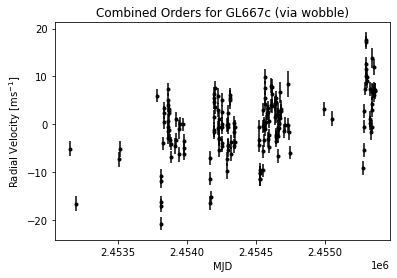

In [6]:
rvs = np.array(results['RV'] - np.median(results['RV'])) #combined orders RVs from Wobble
rvs_err = np.array(results['RV_err']) #combined orders RV errors from Wobble
plt.figure()
plt.errorbar(times, rvs, rvs_err, fmt='.k')
plt.title('Combined Orders for {}'.format(star_name))
plt.ylabel('Radial Velocity [ms$^{-1}$]')
plt.xlabel('MJD')

In [7]:
def plot_rvs(times, rvs, rvs_err, star_name):
    rvs = rvs - np.median(rvs)
    plt.figure()
    plt.errorbar(times, rvs, rvs_err, fmt='.k')
    plt.title('Combined Orders for {}'.format(star_name))
    plt.ylabel('Radial Velocity [ms$^{-1}$]')
    plt.xlabel('MJD')

In [8]:
combined_order_rvs = np.array(results['RV'])
combined_order_rvs_err = np.array(results['RV_err'])

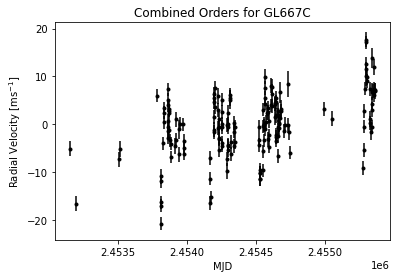

In [9]:
plot_rvs(times, combined_order_rvs, combined_order_rvs_err, 'GL667C')

### Fitting a linear trend to these RVs and subtracting it.

I will use scipy optimize curve fit (I previously used astropy but found it cumbersome, especially to get out the popt/pcov matrices). Start by defining a straight line function and then find the best fit based on the data, and return the popt and pcov matrices and therefore the perr.

- **NOTE - how can I get -1 in the superscript of the unit in the label without it getting confused with the dot formatting {}**

In [10]:
def straight_line (x, m, c):
    return (m * x) + c

In [11]:
def normalise_rvs(rv_data):
    normalised_rvs = rv_data - np.median(rv_data)
    return normalised_rvs


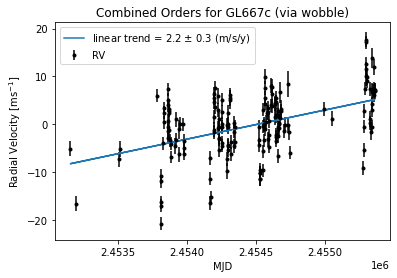

In [12]:
popt, pcov = curve_fit(straight_line, times, rvs, sigma = rvs_err)
perr = np.sqrt(np.diag(pcov))
trend_year_rounded = np.around((popt[0]*365.25), decimals = 1)
trend_year_rounded_err = np.around((perr[0]*365.25), decimals = 1)
plt.figure()
plt.errorbar(times, rvs, rvs_err, fmt='.k', label='RV')
plt.plot(times, straight_line(times, popt[0], popt[1]), label='linear trend = {0} $\pm$ {1} (m/s/y)'.format(trend_year_rounded, trend_year_rounded_err))
plt.title('Combined Orders for {}'.format(star_name))
plt.ylabel('Radial Velocity [ms$^{-1}$]')
plt.xlabel('MJD')
plt.legend()


In [13]:
def linear_fit(times, rvs, rvs_err):
    popt, pcov = curve_fit(straight_line, times, rvs, sigma = rvs_err)
    perr = np.sqrt(np.diag(pcov))
    gradient = popt[0]
    intercept = popt[1]
    gradient_err = perr[0]
    intercept_err = perr[1]
    return np.array([gradient, intercept, gradient_err, intercept_err])

In [14]:
linear_fit(times, rvs, rvs_err)[1]

-14977.834663007843

In [15]:
def plot_rvs(times, rvs, rvs_err, star_name):
    rvs = normalise_rvs(rvs)
    gradient, intercept, gradient_err, intercept_err = linear_fit(times, rvs, rvs_err)
    plt.figure()
    plt.errorbar(times, rvs, rvs_err, fmt='.k')
    plt.plot(times, straight_line(times, gradient, intercept))
    plt.title('Combined Orders for {}'.format(star_name))
    plt.ylabel('Radial Velocity [ms$^{-1}$]')
    plt.xlabel('MJD')

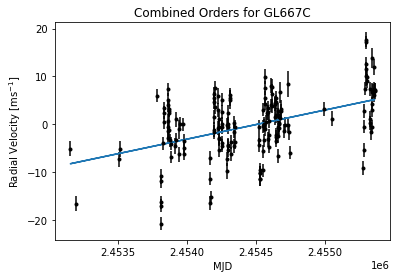

In [16]:
plot_rvs(times, rvs, rvs_err, "GL667C")

### Detrending the RVs for the combined orders

I do this by subtracting the fit from the RVs, I then check that it has worked correctly by fitting a line to the resulting data and verifying that it has a gradient of zero.

In [17]:
detrended = [rvs[i] - (straight_line(times, popt[0], popt[1]))[i] for i in range(0, len(times))]

In [18]:
def detrend_rvs(times, rvs, rvs_err):
    gradient, intercept, gradient_err, intercept_err = linear_fit(times, rvs, rvs_err)
    detrended_rvs = [rvs[i] - (straight_line(times, gradient, intercept))[i] for i in range(0, len(times))]
    return detrended_rvs

In [19]:
detrended_rvs = detrend_rvs(times, rvs, rvs_err)

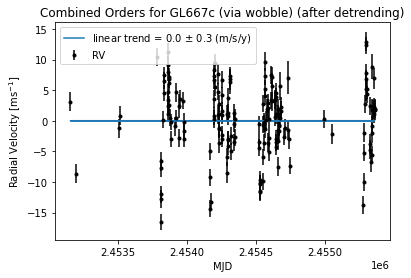

In [20]:
popt_detrended, pcov_detrended = curve_fit(straight_line, times, detrended, sigma = rvs_err)
perr_detrended = np.sqrt(np.diag(pcov_detrended))
detrended_year_rounded = np.around((popt_detrended[0]*365.25), decimals = 1)
detrended_year_rounded_err = np.around((perr_detrended[0]*365.25), decimals = 1)
plt.figure()
plt.errorbar(times, detrended, rvs_err, fmt='.k', label='RV')
plt.plot(times, straight_line(times, popt_detrended[0], popt_detrended[1]), label='linear trend = {0} $\pm$ {1} (m/s/y)'.format(detrended_year_rounded, detrended_year_rounded_err))
plt.title('Combined Orders for {} (after detrending)'.format(star_name))
plt.ylabel('Radial Velocity [ms$^{-1}$]')
plt.xlabel('MJD')
plt.legend()


As expected, the detrended RVs have a trend of 0, so I will now use the same original trend and subtract it from each order to see if there is a residual trend that appears in each order.

## Order by Order
### Identifying the orders / epochs that have NaN in the RV errors

I noticed that some of the RV errors had NaN in, which made fitting for the trend in each difficult. I need to identify the orders and the epochs that these come from, to be able to do further analysis.

Below I create an order by epoch boolean array where if the value of RV_err is NaN the element in the array is True.

### Replacing the NaN values in the order by order RV_errs with np.inf in order to be able to fit the trend properly.

to do this going to slice each order of rvs_err with the boolean mask I created before and assign it to np.inf.

In [20]:
no_of_orders = len(results_hdf5.orders) #number of orders in the results - note, doesn't give which order, I need to get this from the data, but lower numbers are the blue wavelengths
no_of_epochs = len(results_hdf5.epochs) #number of epochs
no_of_elements = no_of_epochs * no_of_orders #total number of elements to give an idea of how many NaNs there are

nan_rvs_err = [] #preassigning an empty list to the nan_rv_errs
rvs_err_inf = [] #preassigning an empty list to save the rvs_errs that have had NaNs replaced with np.inf

for o in range(no_of_orders):
    order_rvs_err = np.array(results['RV_order{}_err'.format(o)]) #getting the uncertainties in the same way
    nan_rvs_err.append(np.isnan(order_rvs_err)) #assigning the locations of the NaN in the order to the list
    #print('Order {0} has {1} out of 172 epochs as NaN ({2}%)'.format(o, np.count_nonzero(np.isnan(order_rvs_err)),np.count_nonzero(np.isnan(order_rvs_err))*100/172)) #checking to see how many NaNs there were before
    order_rvs_isnans = np.isnan(order_rvs_err) #creating a boolean mask for the elements that have NaN
    order_rvs_err[order_rvs_isnans] = np.inf #replacing the elements using the mask with np.inf
    #print('Order {0} has {1} out of 172 epochs as NaN ({2}%)'.format(o, np.count_nonzero(np.isnan(order_rvs_err)),np.count_nonzero(np.isnan(order_rvs_err))*100/172)) #making sure the cleaning the previous 2 lines worked
    rvs_err_inf.append(order_rvs_err)

nan_rvs_err = np.array(nan_rvs_err)
rvs_err = np.array(rvs_err_inf)
    

In [21]:
nan_rvs_err

array([[False, False, False, ...,  True, False, False],
       [False,  True, False, ...,  True, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

Text(0, 0.5, 'Order')

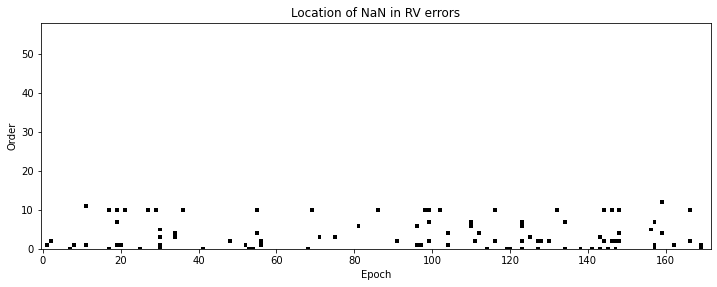

In [112]:
plt.figure(figsize=(12,8))
plt.imshow(nan_rvs_err, cmap='gray_r')
plt.ylim(0,58)
plt.title('Location of NaN in RV errors')
plt.xlabel('Epoch')
plt.ylabel('Order')

### Detrending each order by using the combined orders trend
Each order has the overall trend from the combined orders subtracted and the residual trend calculated.

In [27]:
residual_trends = []
residual_trends_err = []
detrended_rvs_all_orders = []

for o in range(no_of_orders):
    order_rvs = np.array(results['RV_order{}'.format(o)])
    order_rvs = order_rvs - np.median(order_rvs)
    order_rvs_err = rvs_err[o,:]
    order_detrended_rvs = [order_rvs[i] - (straight_line(times, popt[0], popt[1]))[i] for i in range(0, len(times))]
    popt_order, pcov_order = curve_fit(straight_line, times, order_detrended_rvs, sigma = order_rvs_err)
    perr_order = np.sqrt(np.diag(pcov_order))
    # plt.figure()
    # plt.errorbar(times, order_detrended_rvs, order_rvs_err, fmt='.k', label='RV')
    residual_trends.append(popt_order[0])
    residual_trends_err.append(perr_order[0])
    detrended_rvs_all_orders.append(order_detrended_rvs)

# plt.figure()
# plt.errorbar(times, test_order_detrended, test_order_rvs_err, fmt='.k', label='RV')
# plt.plot(times, straight_line(times, popt_order[0], popt_order[1]), label='residual trend = {0} $\pm$ {1} (m/s/y)'.format(order_trend_rounded, order_trend_rounded_err))
# plt.title('Order X for {} (after detrending)'.format(star_name))
# plt.ylabel('Radial Velocity [ms$^{-1}$]')
# plt.xlabel('MJD')
# plt.legend()

residual_trends = np.array(residual_trends)
residual_trends_err = np.array(residual_trends_err)
detrended_rvs_all_orders = np.array(detrended_rvs_all_orders)

### Looking at the residual trend for each order

Periodic signal in the trend residual vs order (wavelength?)

Text(0.5, 1.0, 'RV trend after Combined Order trend subtracted')

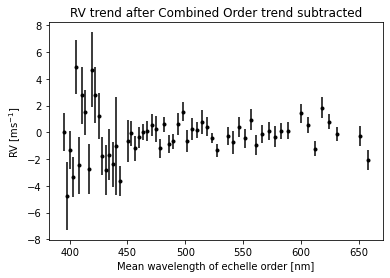

In [113]:
plt.errorbar(wavelengths, residual_trends*365.25, residual_trends_err*365.25, fmt='.k')
plt.ylabel('RV [ms$^{-1}$]')
plt.xlabel('Mean wavelength of echelle order [nm]')
plt.title('RV trend after Combined Order trend subtracted')


## Producing the Lomb-Scargle Periodograms for each order

First saving as variables the literature values for the period of b, c, f, e, g

In [36]:
lit_period_b = 7.2
lit_period_c = 28.1
lit_period_f = 103.1
lit_period_e = 62.24
lit_period_g = 51.6

In [26]:
for o in range(no_of_orders):
    frequency, power = LombScargle(times, detrended_rvs_all_orders[o,:], rvs_err[o,:]).autopower() #run the LS, get freq & power
    # plt.figure()
    # plt.title('LSP for Order {}'.format(o))
    # plt.plot(1/frequency, power) #plotting to check
    # plt.xlim(5,30)
    # plt.ylim(0,0.4)
    # plt.axvline(x = lit_period_b, c='r', ls=':')
    # plt.axvline(x = lit_period_c, c='r', ls=':')
    # plt.axvline(x = lit_period_f, c='r', ls=':')
    # plt.axvline(x = lit_period_e, c='r', ls=':')
    # plt.axvline(x = lit_period_g, c='r', ls=':')
    #plt.savefig('LSP_order_{}'.format(o), dpi=200)



    #plt.xlabel('frequency [days$^{-1}$]')
    #plt.ylabel('Lomb-Scargle Power')
    #plt.title("LS Periodogram for {0}".format(star_name))

### Plotting the LSP for the combined orders from Wobble as a comparison

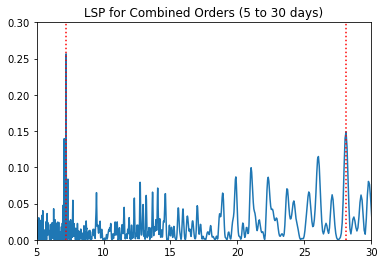

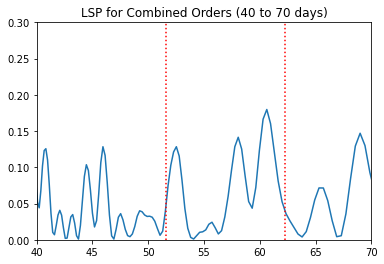

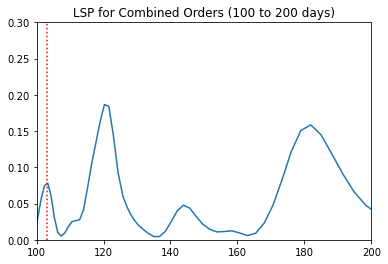

In [27]:
frequency, power = LombScargle(times, detrended, np.array(results['RV_err'])).autopower() 
plt.figure()
plt.title('LSP for Combined Orders (5 to 30 days)')
plt.plot(1/frequency, power) #plotting to check
plt.xlim(5,30)
plt.ylim(0,0.3)
plt.axvline(x = lit_period_b, c='r', ls=':')
plt.axvline(x = lit_period_c, c='r', ls=':')
plt.axvline(x = lit_period_f, c='r', ls=':')
plt.axvline(x = lit_period_e, c='r', ls=':')
plt.axvline(x = lit_period_g, c='r', ls=':')

plt.figure()
plt.title('LSP for Combined Orders (40 to 70 days)')
plt.plot(1/frequency, power) #plotting to check
plt.xlim(40,70)
plt.ylim(0,0.3)
plt.axvline(x = lit_period_b, c='r', ls=':')
plt.axvline(x = lit_period_c, c='r', ls=':')
plt.axvline(x = lit_period_f, c='r', ls=':')
plt.axvline(x = lit_period_e, c='r', ls=':')
plt.axvline(x = lit_period_g, c='r', ls=':')

plt.figure()
plt.title('LSP for Combined Orders (100 to 200 days)')
plt.plot(1/frequency, power) #plotting to check
plt.xlim(100,200)
plt.ylim(0,0.3)
plt.axvline(x = lit_period_b, c='r', ls=':')
plt.axvline(x = lit_period_c, c='r', ls=':')
plt.axvline(x = lit_period_f, c='r', ls=':')
plt.axvline(x = lit_period_e, c='r', ls=':')
plt.axvline(x = lit_period_g, c='r', ls=':')

## Plotting LSP Signal against Wavelength
### Linking order number to wavelength

Need to link through the data that I was using at the start that generated these results:

First the array of bad orders:

In [29]:
bad_orders = np.array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True,  True, False, False,  True,  True,  True,  True])

Secondly the list of good epochs:

In [30]:
good_epochs = [ 0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  30,  31,  32,  33,  34,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  80,
         81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 106, 107,
        108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147,
        148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
        161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
        174, 175, 176]

In [31]:
data = wobble.Data(filename='/home/z5345592/projects/gl667c_wobble/data/gl667c.hdf5', epochs=good_epochs)

In [32]:
data.delete_orders(bad_orders) #deletes the bad orders that have been identified in the 'bad orders' list above. Think of a way to do this beforehand?
data.drop_bad_orders(min_snr=3) #dropping bad orders
data.drop_bad_epochs(min_snr=3) #dropping bad epochs

Data: Dropping orders [0 1 2 3 4 5] because they have average SNR < 3


In [33]:
wavelengths = []
wavelengths_err = []
for o in range(no_of_orders):
    order_wl = (np.exp(np.mean(data.xs[o][0]))/10)
    order_wl_err = (np.exp(np.std(data.xs[o][0]))/10)
    wavelengths.append(order_wl)
    wavelengths_err.append(order_wl_err)
    
wavelengths = np.array(wavelengths)
wavelengths_err = np.array(wavelengths_err)

Now I know what wavelength each order represents, I need to work out an array of powers that is len(orders) long. I need to find what the power is at a certain frequency.

Using the combined order example just to find it once, then I should be able to loop through by order.

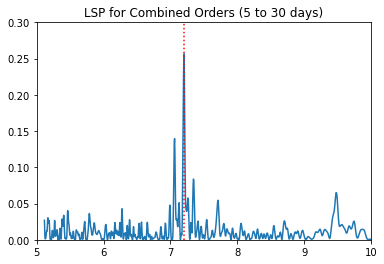

In [71]:
frequency, power = LombScargle(times, detrended, np.array(results['RV_err'])).autopower()
period = 1/frequency
plt.figure()
plt.title('LSP for Combined Orders (5 to 30 days)')
plt.plot(period, power) #plotting to check
plt.xlim(5,10)
plt.ylim(0,0.3)
plt.axvline(x = lit_period_b, c='r', ls=':')
plt.axvline(x = lit_period_c, c='r', ls=':')
plt.axvline(x = lit_period_f, c='r', ls=':')
plt.axvline(x = lit_period_e, c='r', ls=':')
plt.axvline(x = lit_period_g, c='r', ls=':')

In [34]:
def find_nearest(array, value):
    array = np.array(array)
    idx = ((np.abs(array - value)).argmin())
    return idx

Ok, that seems to work pretty well. I did it manually to see what the closest was, and then wrote a quick function to grab the index and then used that function to slice into the power array. Now I should be able to do a loop of the orders and get the power at that point.

In [35]:
ls_power_b = []
ls_power_c = []

for o in range(no_of_orders):
    frequency, power = LombScargle(times, detrended_rvs_all_orders[o,:], rvs_err[o,:]).autopower() #run the LS, get freq & power
    period = 1/frequency
    order_ls_power_b = power[find_nearest(period, lit_period_b)]
    order_ls_power_c = power[find_nearest(period, lit_period_c)]
    ls_power_b.append(order_ls_power_b)
    ls_power_c.append(order_ls_power_c)

ls_power_b = np.array(ls_power_b)
ls_power_c = np.array(ls_power_c)

#np.savetxt('ls_power_b_lr1000', ls_power_b, delimiter=',')
#np.savetxt('ls_power_c_lr1000', ls_power_c, delimiter=',')

In [36]:
ls_power_b_lr20 = np.genfromtxt('ls_power_b_lr20.txt')
ls_power_b_lr100 = np.genfromtxt('ls_power_b_lr100.txt')
ls_power_b_lr1000 = np.genfromtxt('ls_power_b_lr1000.txt')

ls_power_c_lr20 = np.genfromtxt('ls_power_c_lr20.txt')
ls_power_c_lr100 = np.genfromtxt('ls_power_c_lr100.txt')
ls_power_c_lr1000 = np.genfromtxt('ls_power_c_lr1000.txt')

Text(0.5, 1.0, '3 Learning Rate performances for GL667b (P = 7d)')

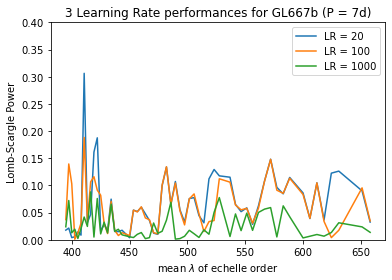

In [37]:
plt.figure()
plt.plot(wavelengths, ls_power_b_lr20, label = 'LR = 20')
plt.plot(wavelengths, ls_power_b_lr100, label = 'LR = 100')
plt.plot(wavelengths, ls_power_b_lr1000, label = 'LR = 1000')
plt.legend(loc = 0)
plt.xlabel('mean $\lambda$ of echelle order')
plt.ylabel('Lomb-Scargle Power')
plt.ylim(0,0.4)
plt.title('3 Learning Rate performances for GL667b (P = 7d)')

Text(0.5, 1.0, '3 Learning Rate performances for GL667c (P = 28d)')

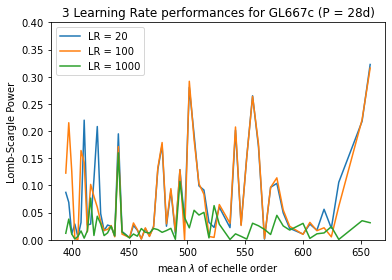

In [38]:
plt.figure()
plt.plot(wavelengths, ls_power_c_lr20, label = 'LR = 20')
plt.plot(wavelengths, ls_power_c_lr100, label = 'LR = 100')
plt.plot(wavelengths, ls_power_c_lr1000, label = 'LR = 1000')
plt.legend(loc = 0)
plt.xlabel('mean $\lambda$ of echelle order')
plt.ylabel('Lomb-Scargle Power')
plt.ylim(0,0.4)
plt.title('3 Learning Rate performances for GL667c (P = 28d)')

## Subtracting a sine wave that corresponds to the RV signal of the planets if they were in perfectly circular orbits.
### The rationale of this is to make sure that any signal that is detected in the periodogram is definitely from that planet and not as a result of 'aliases'
I will start by noting the period and the amplitude that I know from the literature - I have this for both planets, but I do not know well what the phase shift offset is.

In [21]:
lit_period = 7.199
lit_amplitude = 3.8

In [22]:
def sine_wave(x_data, phase_shift):
    return lit_amplitude * (np.sin((2 * np.pi) * (x_data + phase_shift)))

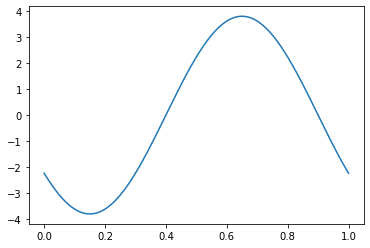

In [24]:
xs = np.linspace(0,1,1000)
ys = sine_wave(xs, -0.4)
plt.plot(xs, ys)

<ErrorbarContainer object of 3 artists>

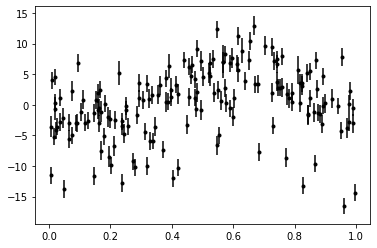

In [25]:
phase_folded = (times / lit_period) % 1
plt.figure()
plt.errorbar(phase_folded, detrended_rvs, rvs_err, fmt='.k')

In [28]:
popt, pcov = curve_fit(sine_wave, phase_folded, detrended_rvs, sigma=rvs_err)
popt

array([0.61689915])

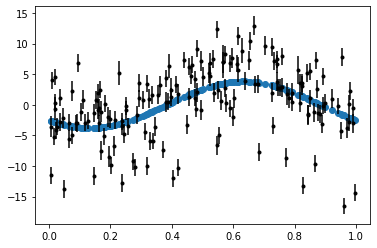

In [29]:
plt.figure()
plt.errorbar(phase_folded, detrended_rvs, rvs_err, fmt='.k')
plt.scatter(phase_folded, sine_wave(phase_folded, popt[0]))

In [33]:
subtracted_7d_signal_data = detrended_rvs - sine_wave(phase_folded, popt[0])

<ErrorbarContainer object of 3 artists>

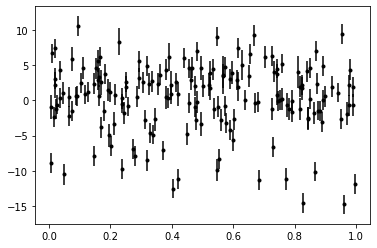

In [34]:
plt.errorbar(phase_folded, subtracted_7d_signal_data, rvs_err, fmt='.k')

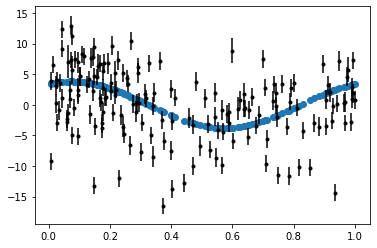

In [46]:
phase_folded = (times / lit_period_c) % 1
popt, pcov = curve_fit(sine_wave, phase_folded, detrended_rvs, sigma=rvs_err)
plt.figure()
plt.errorbar(phase_folded, detrended_rvs, rvs_err, fmt='.k')
plt.scatter(phase_folded, sine_wave(phase_folded, popt[0]))

subtracted_28d_signal_data = detrended_rvs - sine_wave(phase_folded, popt[0])

50.99755183595073


Text(0, 0.5, 'SNR')

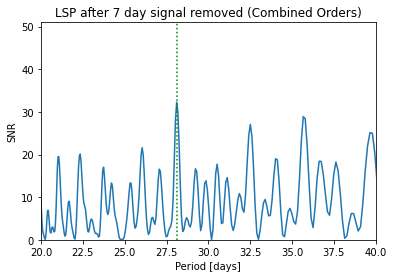

In [43]:
no_7_frequency, no_7_power = LombScargle(times, subtracted_7d_signal_data, np.array(results['RV_err'])).autopower()
no_7_period = 1/no_7_frequency
no_7_noise = np.std(no_7_power[(no_7_period > 6) & (no_7_period < 8)])
no_7_snr = no_7_power / no_7_noise
plt.plot(no_7_period, no_7_snr)
plt.axvline(x = lit_period_b, c='r', ls=':')
plt.axvline(x = lit_period_c, c='g', ls=':')
plt.xlim(20,40)
plt.ylim(0,np.max(no_7_snr))
print(np.max(no_7_snr))
plt.title('LSP after 7 day signal removed (Combined Orders)')
plt.xlabel('Period [days]')
plt.ylabel('SNR')

18.82845503807884


Text(0, 0.5, 'SNR')

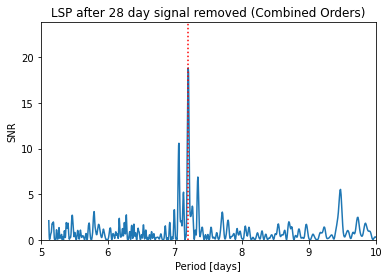

In [50]:
no_28_frequency, no_28_power = LombScargle(times, subtracted_28d_signal_data, np.array(results['RV_err'])).autopower()
no_28_period = 1/no_28_frequency
no_28_noise = np.std(no_28_power[(no_28_period > 25) & (no_28_period < 30)])
no_28_snr = no_28_power / no_28_noise
plt.plot(no_28_period, no_28_snr)
plt.axvline(x = lit_period_b, c='r', ls=':')
plt.axvline(x = lit_period_c, c='g', ls=':')
plt.xlim(5,10)
plt.ylim(0,np.max(no_28_snr+5))
print(np.max(no_28_snr))
plt.title('LSP after 28 day signal removed (Combined Orders)')
plt.xlabel('Period [days]')
plt.ylabel('SNR')


In [ ]:
L